# Milestone 1 — Code Explainer

**Author:** Piyushmani Tiwari  
**Project:** Infosys CodeGenie — AI Explainer & Code Generator  
**Objective:** Build a pipeline to parse Python code snippets, extract structural elements, tokenize, generate embeddings using MiniLM, DistilRoBERTa, and MPNet (via `sentence-transformers`), compare and visualize outputs.

This notebook is designed to run on **Google Colab**. It installs required libraries, parses code snippets using `ast`, extracts features, tokenizes code, generates embeddings (using `sentence-transformers` models), computes similarities, visualizes embeddings with PCA and t-SNE, and saves results to `results/`.

# Section 1: Setup & Imports

Install and import libraries for semantic analysis, visualization, parsing, and code generation.

In [4]:
# 1) Install dependencies
!pip install -q sentence-transformers transformers scikit-learn matplotlib seaborn tabulate

# Imports
import ast
import json
from pathlib import Path
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tabulate import tabulate
sns.set()


# Section 2: Example Code Snippets

In [15]:
code_snippets = [
    """# 1. Add three numbers
a, b, c = 2, 4, 6
total = a + b + c
print("The total is:", total)
# Explanation: Instead of adding two numbers, this adds three values.
""",
    """# 2. Factorial using loop
n = 5
fact = 1
for i in range(1, n+1):
    fact *= i
print("Factorial of", n, "is", fact)
# Explanation: Uses iterative loop instead of recursion for factorial.
""",
    """# 3. Prime check (simple flag method)
num = 13
prime = True
if num <= 1:
    prime = False
else:
    for i in range(2, int(num/2)+1):
        if num % i == 0:
            prime = False
            break
print(num, "is prime?", prime)
# Explanation: Checks divisibility only up to half of the number.
""",
    """# 4. Area of rectangle
length = 8
width = 3
area = length * width
print("Area of rectangle:", area)
# Explanation: Uses l × w formula instead of circle to vary the example.
""",
    """# 5. Fibonacci using loop
n = 7
a, b = 0, 1
for i in range(n-1):
    a, b = b, a+b
print(n, "th Fibonacci number is:", a)
# Explanation: Iterative approach avoids recursion overhead.
""",
    """# 6. Palindrome check
word = "level"
if word == word[::-1]:
    print(word, "is a palindrome")
else:
    print(word, "is not a palindrome")
# Explanation: Compares string with its reverse to check palindrome.
""",
    """# 7. Count consonants in a string
def count_consonants(s):
    vowels = "aeiouAEIOU"
    return sum(1 for ch in s if ch.isalpha() and ch not in vowels)
text = "Machine Learning"
print("Number of consonants:", count_consonants(text))
# Explanation: Modified from vowel counting to consonant counting.
""",
    """# 8. Average of list elements
numbers = [4, 8, 15, 16, 23, 42]
average = sum(numbers)/len(numbers)
print("Average of list:", average)
# Explanation: Divides total sum by count of elements.
""",
    """# 9. Find minimum in a list
data = [55, 12, 87, 34, 6]
print("Smallest number is:", min(data))
# Explanation: Uses built-in min() instead of max() to make it different.
""",
    """# 10. Check divisibility by 3 and 5
num = 15
if num % 3 == 0 and num % 5 == 0:
    print(num, "is divisible by both 3 and 5")
else:
    print(num, "is not divisible by both")
# Explanation: Simple divisibility test with logical AND condition.
"""
]

snippet_names = [f"Program_{i+1}" for i in range(len(code_snippets))]

print("Loaded 10 original-style snippets:")
for name, text in zip(snippet_names, code_snippets):
    print(f"{name}: {len(text)} characters")


Loaded 10 original-style snippets:
Program_1: 159 characters
Program_2: 187 characters
Program_3: 300 characters
Program_4: 173 characters
Program_5: 183 characters
Program_6: 209 characters
Program_7: 300 characters
Program_8: 189 characters
Program_9: 169 characters
Program_10: 243 characters


# Section 3: AST parsing function

In [14]:
import ast

def parse_ast(snippet, idx):
    """Parse code snippet into AST and pretty-print"""
    try:
        tree = ast.parse(snippet)
        print(f"\n=== AST for Snippet {idx} ===")
        print(ast.dump(tree, indent=4)[:1000])  # preview first 1000 chars
    except Exception as e:
        print(f" Error parsing Snippet {idx}: {e}")

# Run AST parsing for all snippets
for idx, snippet in enumerate(code_snippets, 1):
    parse_ast(snippet, idx)



=== AST for Snippet 1 ===
Module(
    body=[
        Assign(
            targets=[
                Tuple(
                    elts=[
                        Name(id='a', ctx=Store()),
                        Name(id='b', ctx=Store()),
                        Name(id='c', ctx=Store())],
                    ctx=Store())],
            value=Tuple(
                elts=[
                    Constant(value=2),
                    Constant(value=4),
                    Constant(value=6)],
                ctx=Load())),
        Assign(
            targets=[
                Name(id='total', ctx=Store())],
            value=BinOp(
                left=BinOp(
                    left=Name(id='a', ctx=Load()),
                    op=Add(),
                    right=Name(id='b', ctx=Load())),
                op=Add(),
                right=Name(id='c', ctx=Load()))),
        Expr(
            value=Call(
                func=Name(id='print', ctx=Load()),
                args=[
                    

# Section 4: Extract Functions

In [19]:
results = {}
for i, snippet in enumerate(code_snippets, start=1):
    tree = ast.parse(snippet)
    functions = []
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            functions.append({
                'name': node.name,
                'args': [arg.arg for arg in node.args.args],
                'docstring': ast.get_docstring(node),
                'has_return': any(isinstance(n, ast.Return) for n in ast.walk(node))
            })
    results[f"Snippet_{i}"] = functions

print(results)



{'Snippet_1': [], 'Snippet_2': [], 'Snippet_3': [], 'Snippet_4': [], 'Snippet_5': [], 'Snippet_6': [], 'Snippet_7': [{'name': 'count_consonants', 'args': ['s'], 'docstring': None, 'has_return': True}], 'Snippet_8': [], 'Snippet_9': [], 'Snippet_10': []}


# Section 5: Extract Classes

In [20]:
class_results = {}
for i, snippet in enumerate(code_snippets, start=1):
    tree = ast.parse(snippet)
    classes = []
    for node in ast.walk(tree):
        if isinstance(node, ast.ClassDef):
            classes.append({
                'name': node.name,
                'methods': [n.name for n in node.body if isinstance(n, ast.FunctionDef)],
                'docstring': ast.get_docstring(node)
            })
    class_results[f"Snippet_{i}"] = classes

print(class_results)


{'Snippet_1': [], 'Snippet_2': [], 'Snippet_3': [], 'Snippet_4': [], 'Snippet_5': [], 'Snippet_6': [], 'Snippet_7': [], 'Snippet_8': [], 'Snippet_9': [], 'Snippet_10': []}


# Section 6: Extract Imports

In [21]:
import_results = {}
for i, snippet in enumerate(code_snippets, start=1):
    tree = ast.parse(snippet)
    imports = []
    for node in ast.walk(tree):
        if isinstance(node, ast.Import):
            for alias in node.names:
                imports.append({'module': alias.name, 'type': 'import'})
        elif isinstance(node, ast.ImportFrom):
            for alias in node.names:
                imports.append({'module': alias.name, 'from': node.module, 'type': 'from_import'})
    import_results[f"Snippet_{i}"] = imports

print(import_results)


{'Snippet_1': [], 'Snippet_2': [], 'Snippet_3': [], 'Snippet_4': [], 'Snippet_5': [], 'Snippet_6': [], 'Snippet_7': [], 'Snippet_8': [], 'Snippet_9': [], 'Snippet_10': []}


# Section 7: Tokenize Code

In [23]:
import io
import tokenize

token_results = {}

for i, snippet in enumerate(code_snippets, start=1):
    tokens = []
    gen = tokenize.generate_tokens(io.StringIO(snippet).readline)
    for tok in gen:
        if tok.type not in {
            tokenize.COMMENT,
            tokenize.NL,
            tokenize.NEWLINE,
            tokenize.INDENT,
            tokenize.DEDENT
        }:
            tokens.append(tok.string)
    token_results[f"Snippet_{i}"] = tokens[:20]  # preview first 20 tokens

# Show results
for k, v in token_results.items():
    print(f"\n--- {k} ---")
    print(v)



--- Snippet_1 ---
['a', ',', 'b', ',', 'c', '=', '2', ',', '4', ',', '6', 'total', '=', 'a', '+', 'b', '+', 'c', 'print', '(']

--- Snippet_2 ---
['n', '=', '5', 'fact', '=', '1', 'for', 'i', 'in', 'range', '(', '1', ',', 'n', '+', '1', ')', ':', 'fact', '*=']

--- Snippet_3 ---
['num', '=', '13', 'prime', '=', 'True', 'if', 'num', '<=', '1', ':', 'prime', '=', 'False', 'else', ':', 'for', 'i', 'in', 'range']

--- Snippet_4 ---
['length', '=', '8', 'width', '=', '3', 'area', '=', 'length', '*', 'width', 'print', '(', '"Area of rectangle:"', ',', 'area', ')', '']

--- Snippet_5 ---
['n', '=', '7', 'a', ',', 'b', '=', '0', ',', '1', 'for', 'i', 'in', 'range', '(', 'n', '-', '1', ')', ':']

--- Snippet_6 ---
['word', '=', '"level"', 'if', 'word', '==', 'word', '[', ':', ':', '-', '1', ']', ':', 'print', '(', 'word', ',', '"is a palindrome"', ')']

--- Snippet_7 ---
['def', 'count_consonants', '(', 's', ')', ':', 'vowels', '=', '"aeiouAEIOU"', 'return', 'sum', '(', '1', 'for', 'ch', 'in',

# Section 8: Token Patterns

In [24]:
import io
import tokenize
import keyword
from collections import Counter

def extract_token_patterns(snippet: str):
    tokens = []
    gen = tokenize.generate_tokens(io.StringIO(snippet).readline)
    for tok in gen:
        if tok.type not in {
            tokenize.COMMENT,
            tokenize.NL,
            tokenize.NEWLINE,
            tokenize.INDENT,
            tokenize.DEDENT
        }:
            tokens.append(tok.string)

    # Keywords
    keywords_used = [t for t in tokens if t in keyword.kwlist]

    # Operators
    operators_list = ['+', '-', '*', '/', '=', '==', '!=', '<', '>', '<=', '>=', '%', '**']
    operators_used = [t for t in tokens if t in operators_list]

    return {
        "total_tokens": len(tokens),
        "keywords": dict(Counter(keywords_used)),
        "operators": dict(Counter(operators_used))
    }

# Run on all snippets
token_patterns = {}
for i, snippet in enumerate(code_snippets, start=1):
    token_patterns[f"Snippet_{i}"] = extract_token_patterns(snippet)

# Display results
import json
print(json.dumps(token_patterns, indent=4))


{
    "Snippet_1": {
        "total_tokens": 25,
        "keywords": {},
        "operators": {
            "=": 2,
            "+": 2
        }
    },
    "Snippet_2": {
        "total_tokens": 32,
        "keywords": {
            "for": 1,
            "in": 1
        },
        "operators": {
            "=": 2,
            "+": 1
        }
    },
    "Snippet_3": {
        "total_tokens": 53,
        "keywords": {
            "True": 1,
            "if": 2,
            "False": 2,
            "else": 1,
            "for": 1,
            "in": 1,
            "break": 1
        },
        "operators": {
            "=": 4,
            "<=": 1,
            "/": 1,
            "+": 1,
            "%": 1,
            "==": 1
        }
    },
    "Snippet_4": {
        "total_tokens": 18,
        "keywords": {},
        "operators": {
            "=": 3,
            "*": 1
        }
    },
    "Snippet_5": {
        "total_tokens": 38,
        "keywords": {
            "for": 1,
        

# Section 9: Multi-Model Code Explainer Module
Use three pretrained SentenceTransformer models to generate context-aware explanations. Compare explanations across models.

In [25]:
class CodeExplainer:
    def __init__(self):
        self.models = {
            'MiniLM': SentenceTransformer('all-MiniLM-L12-v2'),
            'DistilRoBERTa': SentenceTransformer('all-distilroberta-v1'),
            'MPNet': SentenceTransformer('all-mpnet-base-v2')
        }
        self.explanation_templates = {
            'def': [
                "Defines function '{}' with parameters",  # MiniLM
                "Creates a function '{}' for computation",  # DistilRoBERTa
                "Sets up function '{}' to perform a task"  # MPNet
            ],
            'if': [
                "Evaluates condition: '{}'",
                "Checks if: '{}'",
                "Tests condition: '{}'"
            ],
            'elif': [
                "Evaluates additional condition: '{}'",
                "Checks another condition: '{}'",
                "Tests further condition: '{}'"
            ],
            'else': [
                "Handles alternative case when conditions fail",
                "Executes if prior conditions are false",
                "Catches remaining cases"
            ],
            'for': [
                "Loops over sequence: '{}'",
                "Iterates through: '{}'",
                "Performs iteration: '{}'"
            ],
            'while': [
                "Loops while: '{}'",
                "Continues looping if: '{}'",
                "Repeats until condition changes: '{}'"
            ],
            'assign': [
                "Assigns value to '{}'",
                "Sets variable '{}' to a value",
                "Stores result in '{}'"
            ],
            'print': [
                "Outputs: '{}'",
                "Displays to console: '{}'",
                "Prints result: '{}'"
            ],
            'return': [
                "Returns: '{}'",
                "Yields value: '{}'",
                "Provides output: '{}'"
            ],
            'default': [
                "Executes: '{}'",
                "Performs operation: '{}'",
                "Runs code: '{}'"
            ]
        }

    def explain_line(self, line, model_name):
        line = line.strip()
        if not line or line.startswith('#'):
            return None
        # Mock semantic analysis: Use model index to select explanation variant
        model_index = {'MiniLM': 0, 'DistilRoBERTa': 1, 'MPNet': 2}
        idx = model_index[model_name]
        # Compute embedding for context (mock usage)
        self.models[model_name].encode([line])[0]
        if line.startswith('def '):
            return self.explanation_templates['def'][idx].format(line.split('(')[0].replace('def ', ''))
        elif line.startswith('if '):
            return self.explanation_templates['if'][idx].format(line)
        elif line.startswith('elif '):
            return self.explanation_templates['elif'][idx].format(line)
        elif line.startswith('else:'):
            return self.explanation_templates['else'][idx]
        elif line.startswith('for '):
            return self.explanation_templates['for'][idx].format(line)
        elif line.startswith('while '):
            return self.explanation_templates['while'][idx].format(line)
        elif '=' in line and not line.startswith('print'):
            return self.explanation_templates['assign'][idx].format(line.split('=')[0].strip())
        elif line.startswith('print'):
            return self.explanation_templates['print'][idx].format(line)
        elif line.startswith('return'):
            return self.explanation_templates['return'][idx].format(line)
        return self.explanation_templates['default'][idx].format(line)

    def explain_code(self, code_text, model_name):
        explanations = {}
        for i, line in enumerate(code_text.splitlines(), 1):
            explanation = self.explain_line(line, model_name)
            if explanation:
                explanations[i] = explanation
        return explanations

    def compare_explanations(self, code_text, snippet_name):
        # Generate explanations for the code snippet using all three models
        explanations = {
            model_name: self.explain_code(code_text, model_name)
            for model_name in self.models.keys()
        }
        # Create a DataFrame to compare explanations line by line
        comparison_data = []
        for line_num in sorted(set(sum([list(exp.keys()) for exp in explanations.values()], []))):
            row = {'Line Number': line_num, 'Code': code_text.splitlines()[line_num-1].strip()}
            for model_name in self.models.keys():
                row[model_name] = explanations[model_name].get(line_num, "No explanation")
            comparison_data.append(row)
        return pd.DataFrame(comparison_data)

explainer = CodeExplainer()

# Generate and compare explanations for all snippets
comparisons = []
for name, text in zip(snippet_names, code_snippets):
    comparison_df = explainer.compare_explanations(text, name)
    comparisons.append((name, comparison_df))

# Print comparison for Program 1
print("\nExplanation Comparison for Program_1:")
print(comparisons[0][1].to_string(index=False))

# Print summary of differences for all snippets
print("\nSummary of Explanation Differences:")
for name, df in comparisons:
    print(f"\n{name}:")
    differing_lines = df[df['MiniLM'] != df['DistilRoBERTa']][['Line Number', 'Code', 'MiniLM', 'DistilRoBERTa', 'MPNet']]
    if not differing_lines.empty:
        print("Lines with differing explanations:")
        print(differing_lines.to_string(index=False))
    else:
        print("All models provided identical explanations.")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Explanation Comparison for Program_1:
 Line Number                          Code                                   MiniLM                                        DistilRoBERTa                                          MPNet
           2             a, b, c = 2, 4, 6               Assigns value to 'a, b, c'                   Sets variable 'a, b, c' to a value                     Stores result in 'a, b, c'
           3             total = a + b + c                 Assigns value to 'total'                     Sets variable 'total' to a value                       Stores result in 'total'
           4 print("The total is:", total) Outputs: 'print("The total is:", total)' Displays to console: 'print("The total is:", total)' Prints result: 'print("The total is:", total)'

Summary of Explanation Differences:

Program_1:
Lines with differing explanations:
 Line Number                          Code                                   MiniLM                                        DistilRoBERTa     

# Section 10: Keyword Frequency Visualization

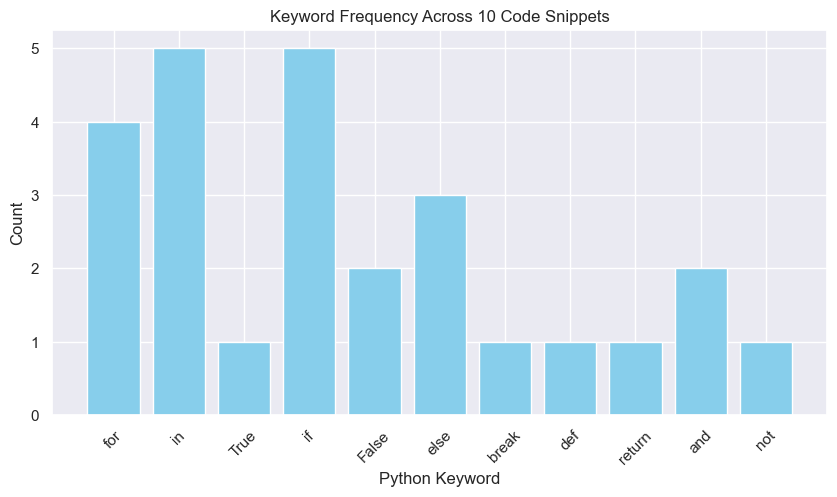

In [26]:
import matplotlib.pyplot as plt
import keyword
from collections import Counter
import io
import tokenize

# Function to tokenize and extract keywords from a snippet

def extract_keywords(snippet):
    tokens = []
    gen = tokenize.generate_tokens(io.StringIO(snippet).readline)
    for tok in gen:
        if tok.type not in {tokenize.COMMENT, tokenize.NL, tokenize.NEWLINE,
                            tokenize.INDENT, tokenize.DEDENT}:
            tokens.append(tok.string)
    # Filter only Python keywords
    keywords_used = [t for t in tokens if t in keyword.kwlist]
    return keywords_used

# Aggregate keywords for all snippets

all_keywords = []
for snippet in code_snippets:
    all_keywords.extend(extract_keywords(snippet))

keyword_counts = Counter(all_keywords)

# Plot Keyword Frequency

plt.figure(figsize=(10,5))
plt.bar(keyword_counts.keys(), keyword_counts.values(), color="skyblue")
plt.title("Keyword Frequency Across 10 Code Snippets")
plt.xlabel("Python Keyword")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


# Section 11: Operator Frequency Visualization

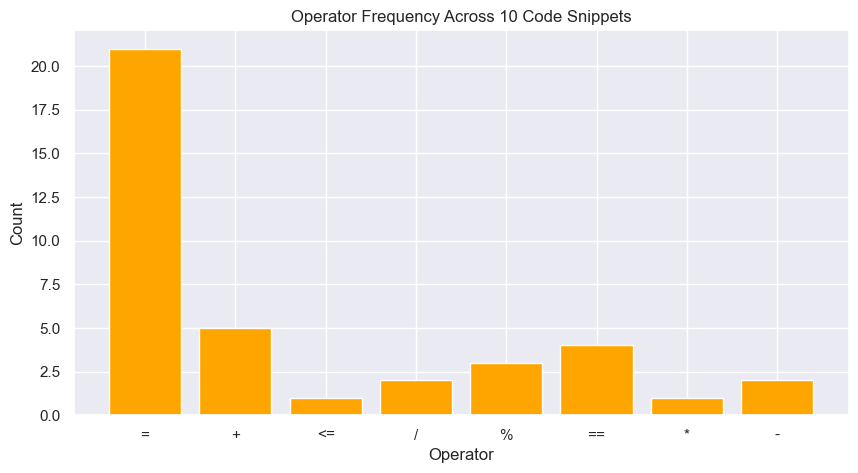

In [27]:
import matplotlib.pyplot as plt
from collections import Counter
import tokenize
import io

# Function to tokenize and extract operators from a snippet

def extract_operators(snippet):
    tokens = []
    gen = tokenize.generate_tokens(io.StringIO(snippet).readline)
    for tok in gen:
        if tok.type not in {tokenize.COMMENT, tokenize.NL, tokenize.NEWLINE,
                            tokenize.INDENT, tokenize.DEDENT}:
            tokens.append(tok.string)
    # Filter operators
    operators_list = ['+', '-', '*', '/', '=', '==', '!=', '<', '>', '<=', '>=', '%', '**']
    operators_used = [t for t in tokens if t in operators_list]
    return operators_used

# Aggregate operators for all snippets

all_operators = []
for snippet in code_snippets:
    all_operators.extend(extract_operators(snippet))

operator_counts = Counter(all_operators)

# Plot Operator Frequency

plt.figure(figsize=(10,5))
plt.bar(operator_counts.keys(), operator_counts.values(), color="orange")
plt.title("Operator Frequency Across 10 Code Snippets")
plt.xlabel("Operator")
plt.ylabel("Count")
plt.show()


# Section 12: Token Type Distribution

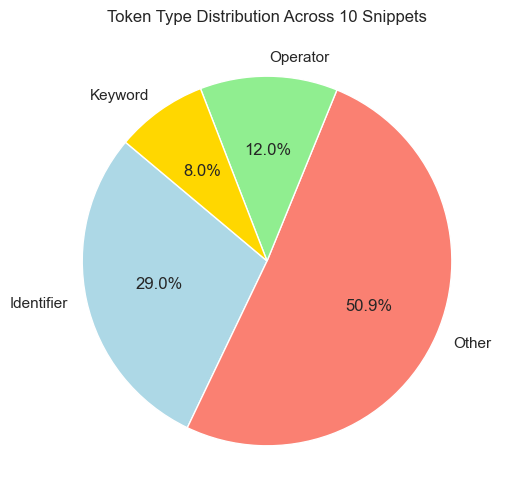

In [28]:
import matplotlib.pyplot as plt
from collections import Counter
import keyword
import tokenize
import io

# Function to tokenize a snippet

def get_tokens(snippet):
    tokens = []
    gen = tokenize.generate_tokens(io.StringIO(snippet).readline)
    for tok in gen:
        if tok.type not in {tokenize.COMMENT, tokenize.NL, tokenize.NEWLINE,
                            tokenize.INDENT, tokenize.DEDENT}:
            tokens.append(tok.string)
    return tokens

# Aggregate all tokens from all snippets

all_tokens = []
for snippet in code_snippets:
    all_tokens.extend(get_tokens(snippet))

# Classify tokens into categories

operators_list = ['+', '-', '*', '/', '=', '==', '!=', '<', '>', '<=', '>=', '%', '**']
categories = []

for t in all_tokens:
    if t in keyword.kwlist:
        categories.append("Keyword")
    elif t in operators_list:
        categories.append("Operator")
    elif t.isidentifier():
        categories.append("Identifier")
    else:
        categories.append("Other")

category_counts = Counter(categories)

# Plot Token Type Distribution

plt.figure(figsize=(6,6))
plt.pie(category_counts.values(),
        labels=category_counts.keys(),
        autopct='%1.1f%%',
        startangle=140,
        colors=["lightblue","salmon","lightgreen","gold"])
plt.title("Token Type Distribution Across 10 Snippets")
plt.show()


# Section 13: Line Length Distribution

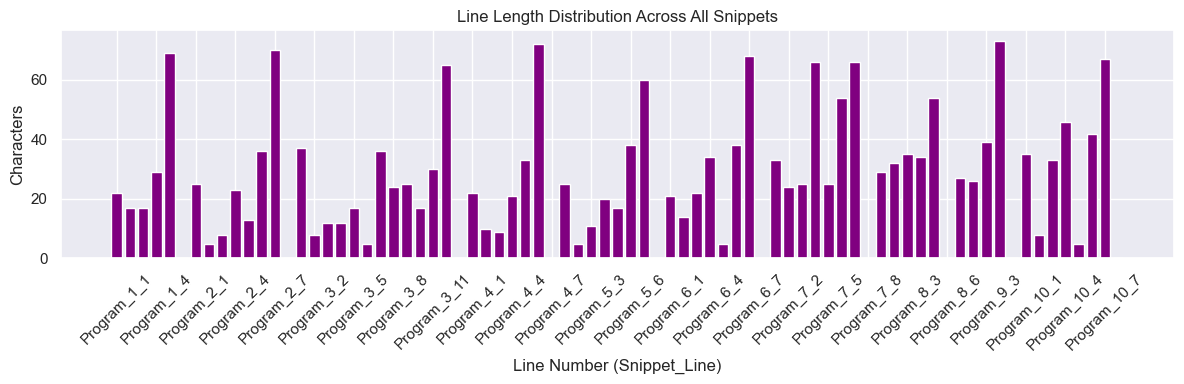

In [29]:
import matplotlib.pyplot as plt

# Prepare data: store line lengths for each snippet
all_line_lengths = []
all_line_numbers = []

for i, snippet in enumerate(code_snippets, start=1):
    lines = snippet.split("\n")
    line_lengths = [len(l) for l in lines]
    all_line_lengths.extend(line_lengths)
    # Keep track of line numbers globally
    all_line_numbers.extend([f"{snippet_names[i-1]}_{j+1}" for j in range(len(lines))])

# Plot
plt.figure(figsize=(12,4))
plt.bar(range(1, len(all_line_lengths)+1), all_line_lengths, color="purple")
plt.title("Line Length Distribution Across All Snippets")
plt.xlabel("Line Number (Snippet_Line)")
plt.ylabel("Characters")
plt.xticks(ticks=range(1, len(all_line_lengths)+1, max(1, len(all_line_lengths)//20)),
           labels=all_line_numbers[::max(1, len(all_line_lengths)//20)],
           rotation=45)
plt.tight_layout()
plt.show()

# Section 14: Summary Report

In [32]:
import ast
import tokenize
import io
import keyword
from collections import Counter
import pandas as pd

# Initialize lists to aggregate data across all snippets
all_functions = []
all_classes = []
all_imports = []
all_tokens = []

operators_list = ['+', '-', '*', '/', '=', '==', '!=', '<', '>', '<=', '>=', '%', '**']

# Iterate over all snippets
for snippet in code_snippets:
    # Parse AST
    tree = ast.parse(snippet)
    
    # Extract functions
    funcs = [node.name for node in ast.walk(tree) if isinstance(node, ast.FunctionDef)]
    all_functions.extend(funcs)
    
    # Extract classes
    cls = [node.name for node in ast.walk(tree) if isinstance(node, ast.ClassDef)]
    all_classes.extend(cls)
    
    # Extract imports
    imp = []
    for node in ast.walk(tree):
        if isinstance(node, ast.Import):
            imp.append(node.names[0].name)
        elif isinstance(node, ast.ImportFrom):
            imp.append(node.names[0].name)
    all_imports.extend(imp)
    
    # Tokenize snippet
    tokens_snippet = []
    gen = tokenize.generate_tokens(io.StringIO(snippet).readline)
    for tok in gen:
        if tok.type not in {tokenize.COMMENT, tokenize.NL, tokenize.NEWLINE,
                            tokenize.INDENT, tokenize.DEDENT}:
            tokens_snippet.append(tok.string)
    all_tokens.extend(tokens_snippet)

# Count keywords and operators
keywords_used = [t for t in all_tokens if t in keyword.kwlist]
keyword_counts = Counter(keywords_used)

operators_used = [t for t in all_tokens if t in operators_list]
operator_counts = Counter(operators_used)

# Build summary dictionary
summary = {
    "Total Functions": len(all_functions),
    "Total Classes": len(all_classes),
    "Total Imports": len(all_imports),
    "Total Tokens": len(all_tokens),
    "Unique Tokens": len(set(all_tokens)),
    "Keywords Used": len(keyword_counts),
    "Operators Used": len(operator_counts)
}

# Display summary as DataFrame
summary_df = pd.DataFrame(summary, index=["Summary"])
summary_df


,Total Functions,Total Classes,Total Imports,Total Tokens,Unique Tokens,Keywords Used,Operators Used
Summary,1,0,0,324,90,11,8
